## Notebook for evaluating our grade prediction model

In [1]:
import torch
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
plt.rcParams['figure.figsize'] = [10, 10]

#load in the model
from models.CNN_model import get_cnn_model
CNN_model = get_cnn_model()
from models.NN_model import get_model
NN_model = get_model()

#load model weights...
NN_model.load_state_dict(torch.load('NN_random_split_weights.pt'))
NN_model.eval()

#CNN_model.load_state_dict(torch.load('CNN_random_split_weights.pt'))
CNN_model.load_state_dict(torch.load('grade_predictor.pt'))
CNN_model.eval()

ConvNeuralNet(
  (conv_layer1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_layer2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_layer3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_layer4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_layer5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_layer6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (global_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=512, out_features=1028, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=1028, out_features=1, bias=True)
)

In [2]:
classes = ['6B+','6C','6C+','7A','7A+','7B','7B+','7C','7C+','8A']

In [3]:
#get the test data
from dataset import MoonboardDataset

#testing with a random split
def get_random_split_dataset(flatten):
    random_split_dataset = MoonboardDataset('2016_moonboard_problems.csv',flatten=flatten,full_dataset=True)
    generator = torch.Generator().manual_seed(1337)
    train_size = int(0.8 * len(random_split_dataset))
    test_size = len(random_split_dataset) - train_size
    _, random_split_test_dataset = torch.utils.data.random_split(random_split_dataset, [train_size, test_size], generator=generator)
    return random_split_test_dataset
    
NN_test_dataset = get_random_split_dataset(flatten=True)
CNN_test_dataset = get_random_split_dataset(flatten=False)

In [4]:
def get_preds(model,dataset):

    predictions = []
    int_predictions = []
    all_labels = []

    from torch.utils.data import DataLoader
    test_dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

    for i,data in enumerate(test_dataloader):
        inputs,labels = data
        preds = model(inputs.float())

        for label in labels:
            all_labels.append(int(label.item()))
        for pred in preds:
            predictions.append(pred.item())
            int_predictions.append(int(pred.item()))

    all_labels = np.asarray(all_labels)
    predictions = np.asarray(predictions)
    int_predictions = np.asarray(int_predictions)
    
    return all_labels,predictions,int_predictions

In [5]:
random_split_labels,NN_predictions,NN_int_predictions = get_preds(NN_model,NN_test_dataset)
_,CNN_predictions,CNN_int_predictions = get_preds(CNN_model,CNN_test_dataset)

print('model accuracy:',100*np.sum(random_split_labels==NN_int_predictions)/len(NN_int_predictions))
print('model accuracy:',100*np.sum(random_split_labels==CNN_int_predictions)/len(CNN_int_predictions))


print(CNN_predictions)
#plusminus1 - accuracy
total_correct = 0
for i,pred in enumerate(NN_int_predictions):
    if pred in [random_split_labels[i],random_split_labels[i]-1,random_split_labels[i]+1]:
        total_correct +=1
print('model accuracy +-1:',total_correct/len(NN_int_predictions))

total_correct = 0
for i,pred in enumerate(CNN_int_predictions):
    if pred in [random_split_labels[i],random_split_labels[i]-1,random_split_labels[i]+1]:
        total_correct +=1
print('model accuracy +-1:',total_correct/len(CNN_int_predictions))


model accuracy: 71.42857142857143
model accuracy: 59.44907110826394
[ 4.07635197e-02  5.63869476e+00 -2.21489072e-02 ...  2.06087157e-03
  2.59853117e-02  2.73505449e-01]
model accuracy +-1: 0.9590006406149904
model accuracy +-1: 0.8007687379884689


## Look at the predicted grades made by the Neural Network

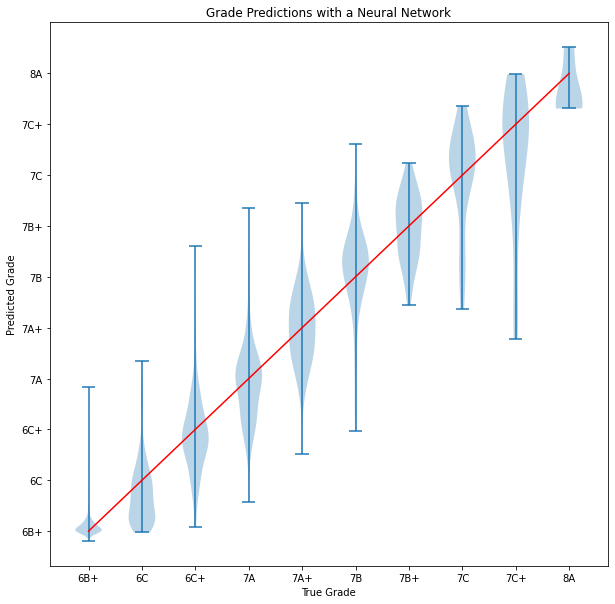

In [6]:
#plt.scatter(all_labels,NN_predictions)
all_data = []

for i in range(12):
    all_data.append(NN_predictions[np.where(random_split_labels==i)])
    
plt.violinplot(all_data[:10],range(10))
#plt.scatter(10,all_data[10],marker='x',c='tab:blue')
#plt.scatter(11,all_data[11],marker='x',c='tab:blue')
plt.xlabel('True Grade')
plt.ylabel('Predicted Grade')
plt.yticks(np.arange(10),classes)
plt.plot(np.arange(10),np.arange(10),c='red')
plt.xticks(np.arange(10),classes)
plt.title('Grade Predictions with a Neural Network')
plt.show()

## Look at the predicted grades made by the Convolotional Neural Network

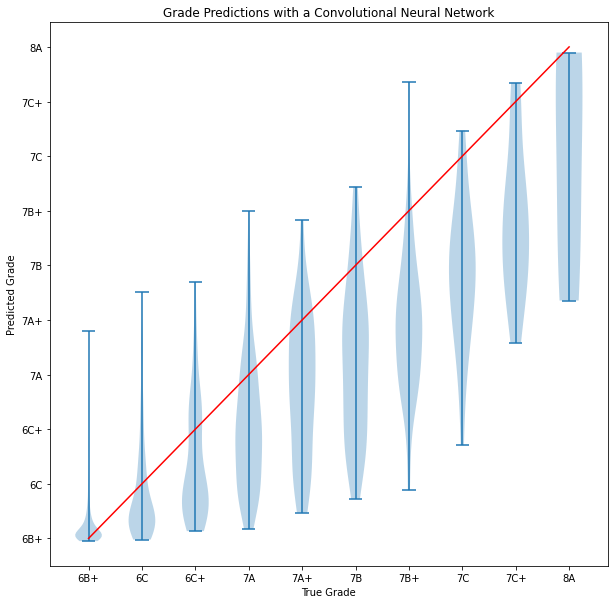

In [7]:
#plt.scatter(all_labels,NN_predictions)
all_data = []

for i in range(12):
    all_data.append(CNN_predictions[np.where(random_split_labels==i)])
    
plt.violinplot(all_data[:10],range(10))
#plt.scatter(10,all_data[10],marker='x',c='tab:blue')
#plt.scatter(11,all_data[11],marker='x',c='tab:blue')
plt.xlabel('True Grade')
plt.ylabel('Predicted Grade')
plt.yticks(np.arange(10),classes)
plt.plot(np.arange(10),np.arange(10),c='red')
plt.xticks(np.arange(10),classes)
plt.title('Grade Predictions with a Convolutional Neural Network')
plt.show()

## Create a confusion matricies for the Neural Network predictions

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(random_split_labels, NN_int_predictions)
norm_cm = confusion_matrix(random_split_labels, NN_int_predictions,normalize='true')

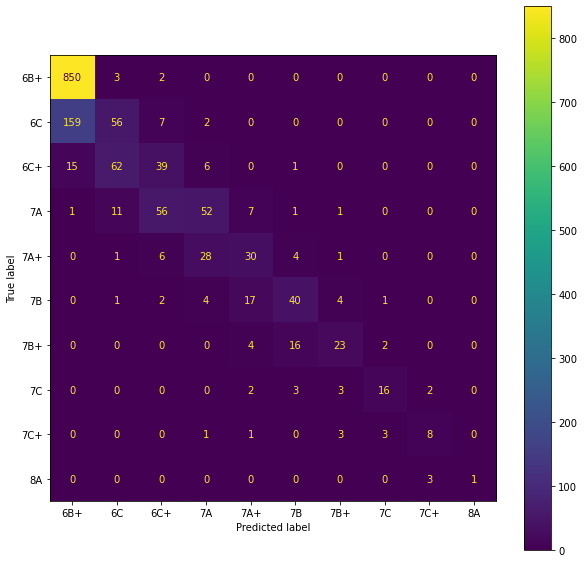

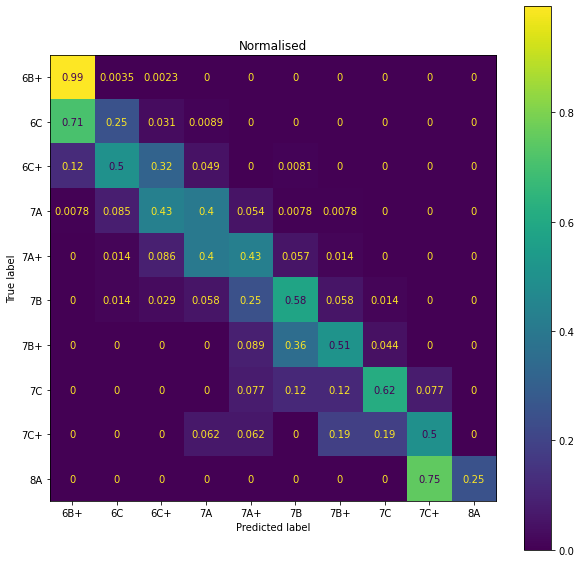

In [9]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes)
disp.plot()
plt.show()

disp = ConfusionMatrixDisplay(confusion_matrix=norm_cm,display_labels=classes)
disp.plot()
plt.title('Normalised')
plt.show()

## Create a confusion matricies for the Convolutional Neural Network predictions

In [10]:
cm = confusion_matrix(random_split_labels, CNN_int_predictions)
norm_cm = confusion_matrix(random_split_labels, CNN_int_predictions,normalize='true')

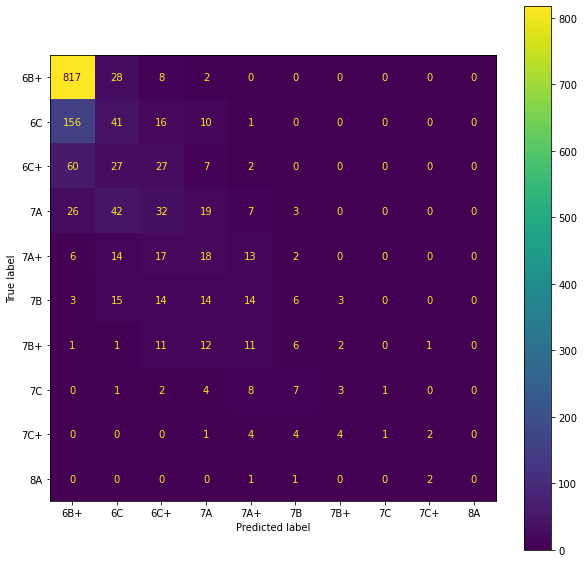

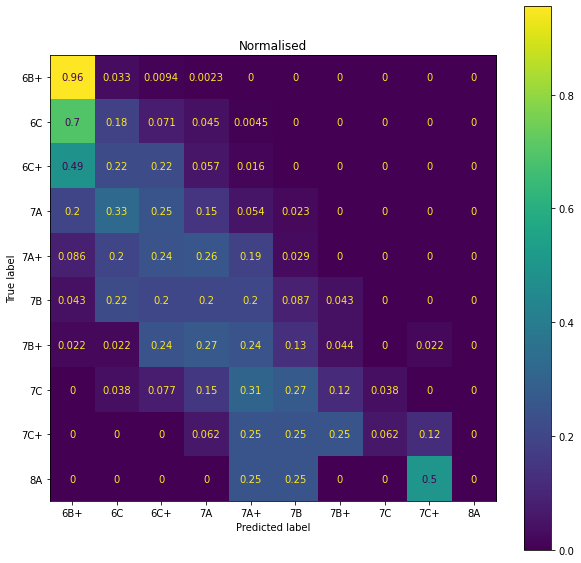

In [11]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes)
disp.plot()
plt.show()

disp = ConfusionMatrixDisplay(confusion_matrix=norm_cm,display_labels=classes)
disp.plot()
plt.title('Normalised')
plt.show()

### CNN performs worse, this make some sense due to pooling operations removing exact hold relations.
While pooling is very useful for processing image data, it hinders exact hold relations.
The CNN also only about 1/6th the size of the neural network, however it is hard to scale it up on such a small input.